# Imports

In [59]:
# Core
import sys
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import chi2_contingency, ttest_ind

# Auto-reload for development
%load_ext autoreload
%autoreload 2

# Scikit-learn: preprocessing, model selection, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    average_precision_score,
    PrecisionRecallDisplay
)

# Modeling
import xgboost as xgb

# Hyperparameter tuning
import optuna


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Script Configuration

In [60]:
# --- SCRIPT CONFIGURATION ---
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Loading Data

In [61]:
print("--- Loading Data ---")
df = pd.read_csv('Fraudulent_E-Commerce_Transaction_Data_2.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df = df.sort_values('transaction_date').reset_index(drop=True)
print("Data loaded, cleaned, and sorted by date.")

--- Loading Data ---
Data loaded, cleaned, and sorted by date.


# Displaying Data

In [62]:
df_eda = df.copy()
df_eda

,transaction_id,customer_id,transaction_amount,transaction_date,payment_method,product_category,quantity,customer_age,customer_location,device_used,ip_address,shipping_address,billing_address,is_fraudulent,account_age_days,transaction_hour
0,768305b2-10c3-49b6-a1cb-cb8e482d2e68,14553f1a-a019-4a8f-8ee1-99202119cb73,127.49,2024-01-01 00:01:19,PayPal,clothing,5,32,East Brittany,tablet,180.30.243.56,"021 Monica Ferry Apt. 901\nKellytown, PR 81572","PSC 7859, Box 5915\nAPO AA 55320",0,70,0
1,afb10e10-d0a2-4c2e-943c-a43e36f1efff,66789b12-f61c-4d2d-b7b8-c31c3b5e8e03,329.85,2024-01-01 00:02:06,bank transfer,toys & games,1,28,Kennethchester,desktop,173.56.93.91,"58287 Hall Stravenue Suite 686\nEast James, CA...","58287 Hall Stravenue Suite 686\nEast James, CA...",0,264,0
2,6e74e684-2bc2-47ae-a4ea-81841d273dfa,954554de-f7d3-4132-a2e7-1ad095edd665,483.91,2024-01-01 00:06:18,bank transfer,toys & games,3,44,Jacobhaven,mobile,89.148.204.128,"37652 Melissa Highway\nWest Joseph, TX 99765","37652 Melissa Highway\nWest Joseph, TX 99765",0,243,0
3,057951e6-134b-4fd7-b33e-d8d84b4b1ed6,edd11223-c2a2-42a0-9e69-a0b1cc2a0171,208.45,2024-01-01 00:07:06,PayPal,electronics,2,16,Port Kevinland,desktop,194.4.142.31,"16711 Flores Shore Suite 706\nAndrewport, AK 1...","16711 Flores Shore Suite 706\nAndrewport, AK 1...",0,217,0
4,ba31ed3b-c469-4805-8364-f882fbc062e5,d904a9d7-b4ca-4940-bc72-b88fe02b7b8d,52.33,2024-01-01 00:09:35,credit card,clothing,5,25,Leeton,desktop,38.106.35.163,"6005 Allen Crest Suite 301\nNorth Tanya, MP 90653","6005 Allen Crest Suite 301\nNorth Tanya, MP 90653",0,250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23629,ddef994f-96fd-4785-b7c2-ca1cabe67cb8,b6c4c265-b84f-446b-9428-82550da3549c,58.02,2024-04-07 08:27:35,bank transfer,home & garden,5,28,Shannonport,mobile,118.27.173.39,"6928 Fisher Trail\nRachelport, TX 49174","6928 Fisher Trail\nRachelport, TX 49174",0,45,8
23630,82a0fea0-502d-405c-8c9e-31bc2a96df86,3865818f-0305-4086-9039-e979b92a2765,15.10,2024-04-07 08:32:35,credit card,home & garden,2,42,Melodyland,mobile,128.239.90.199,"29634 Jake Skyway Apt. 515\nPrincemouth, NC 06591",USNS Mcintyre\nFPO AE 60849,0,225,8
23631,f4d680cc-f2a0-416a-a450-27ca5dc600bc,8fc5f92a-b8bb-4eb4-b83d-92fabc54e3eb,494.22,2024-04-07 08:35:25,PayPal,health & beauty,1,25,New Christopher,desktop,33.208.0.93,"1096 Castro Unions\nSouth Regina, TN 28722","1096 Castro Unions\nSouth Regina, TN 28722",0,21,8
23632,9245c024-8c51-441f-92d7-551f0a7edb7b,d2e6ef55-6199-4b1d-827d-306fb0996cf4,75.36,2024-04-07 08:39:04,bank transfer,clothing,4,35,Huffmanchester,tablet,168.214.110.99,"3406 Donna Radial\nNorth Elizabethport, PA 35918","3406 Donna Radial\nNorth Elizabethport, PA 35918",0,131,8


In [63]:
# Display df_eda shape
print(df_eda.shape)

(23634, 16)


In [64]:
# Display info about the DataFrame
print(df_eda.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      23634 non-null  object        
 1   customer_id         23634 non-null  object        
 2   transaction_amount  23634 non-null  float64       
 3   transaction_date    23634 non-null  datetime64[ns]
 4   payment_method      23634 non-null  object        
 5   product_category    23634 non-null  object        
 6   quantity            23634 non-null  int64         
 7   customer_age        23634 non-null  int64         
 8   customer_location   23634 non-null  object        
 9   device_used         23634 non-null  object        
 10  ip_address          23634 non-null  object        
 11  shipping_address    23634 non-null  object        
 12  billing_address     23634 non-null  object        
 13  is_fraudulent       23634 non-null  int64     

In [65]:
# Display first few rows of the DataFrame
print(df_eda.head())

                         transaction_id                           customer_id  \
0  768305b2-10c3-49b6-a1cb-cb8e482d2e68  14553f1a-a019-4a8f-8ee1-99202119cb73   
1  afb10e10-d0a2-4c2e-943c-a43e36f1efff  66789b12-f61c-4d2d-b7b8-c31c3b5e8e03   
2  6e74e684-2bc2-47ae-a4ea-81841d273dfa  954554de-f7d3-4132-a2e7-1ad095edd665   
3  057951e6-134b-4fd7-b33e-d8d84b4b1ed6  edd11223-c2a2-42a0-9e69-a0b1cc2a0171   
4  ba31ed3b-c469-4805-8364-f882fbc062e5  d904a9d7-b4ca-4940-bc72-b88fe02b7b8d   

   transaction_amount    transaction_date payment_method product_category  \
0              127.49 2024-01-01 00:01:19         PayPal         clothing   
1              329.85 2024-01-01 00:02:06  bank transfer     toys & games   
2              483.91 2024-01-01 00:06:18  bank transfer     toys & games   
3              208.45 2024-01-01 00:07:06         PayPal      electronics   
4               52.33 2024-01-01 00:09:35    credit card         clothing   

   quantity  customer_age customer_location device

In [66]:
# Display summary statistics of the DataFrame
print(df_eda.describe())

       transaction_amount               transaction_date      quantity  \
count        23634.000000                          23634  23634.000000   
mean           229.367099  2024-02-18 15:17:19.427942656      3.000550   
min             10.000000            2024-01-01 00:01:19      1.000000   
25%             69.070000  2024-01-24 21:05:15.750000128      2.000000   
50%            151.415000            2024-02-18 21:18:54      3.000000   
75%            296.127500     2024-03-14 00:01:59.500000      4.000000   
max           9716.500000            2024-04-07 08:54:03      5.000000   
std            282.046669                            NaN      1.419663   

       customer_age  is_fraudulent  account_age_days  transaction_hour  
count  23634.000000   23634.000000      23634.000000      23634.000000  
mean      34.560210       0.051705        178.660531         11.266015  
min       -2.000000       0.000000          1.000000          0.000000  
25%       28.000000       0.000000       

# Exploratory Data Analysis

## Check for missing values

In [67]:
# Check for missing values
missing_values = df_eda.isnull().sum()
print(missing_values)

transaction_id        0
customer_id           0
transaction_amount    0
transaction_date      0
payment_method        0
product_category      0
quantity              0
customer_age          0
customer_location     0
device_used           0
ip_address            0
shipping_address      0
billing_address       0
is_fraudulent         0
account_age_days      0
transaction_hour      0
dtype: int64


Insight: No missing values, no need for dropping or filling of data

## Distribution of Target Variable

is_fraudulent
0    22412
1     1222
Name: count, dtype: int64


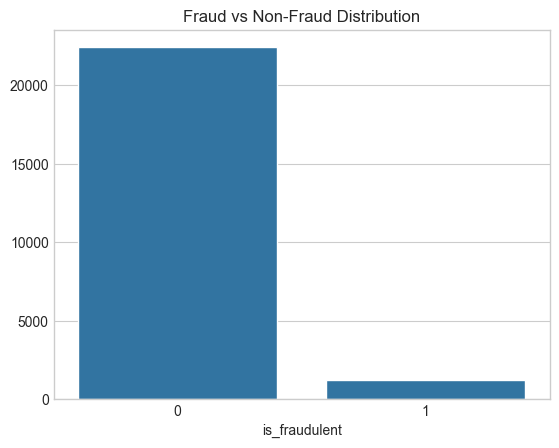

Fraud Ratio: 5.17051705170517%


In [68]:
# Visualize the distribution of the target variable
fraud_counts = df_eda['is_fraudulent'].value_counts()
print(fraud_counts)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()
print(f"Fraud Ratio: {df_eda['is_fraudulent'].mean() * 100}%")

Insight: The dataset is highly imbalanced. Only about 5.17% of the transactions are fraudulent. This is a critical finding. It means that a model that simply predicts "not fraudulent" every time will be 94.83% accurate. Therefore, accuracy is a poor metric for this problem. We must focus on metrics like Precision, Recall, F1-Score, and the AUC-ROC curve for classification task. Additionally, we might have to use methods like oversampling the minority class, undersampling the majority class or applying class weights.

## Transaction Amount by Fraud Status

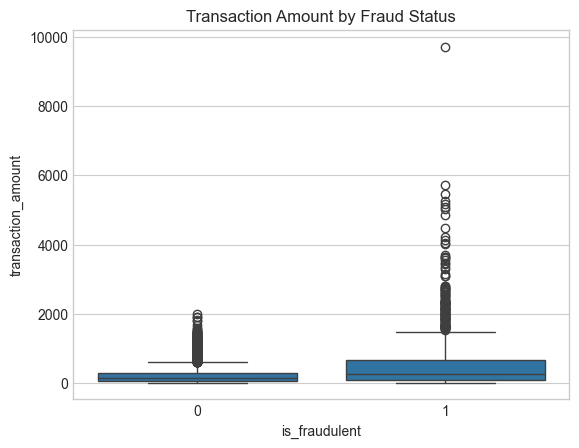

In [69]:
# Visualize transaction amounts for fraudulent vs non-fraudulent transactions
sns.boxplot(x='is_fraudulent', y='transaction_amount', data=df_eda)
plt.title("Transaction Amount by Fraud Status")
plt.show()

Insight: While the median transaction amount is slightly higher for fraudulent transactions, the most significant difference is in the variance and presence of high-value outliers. The fraudulent group has a much wider spread of transaction amounts and contains many more extreme high-value transactions. This suggests that Transaction Amount is a valuable feature, especially for identifying unusually large purchases.

## Distribution of Numeric Features

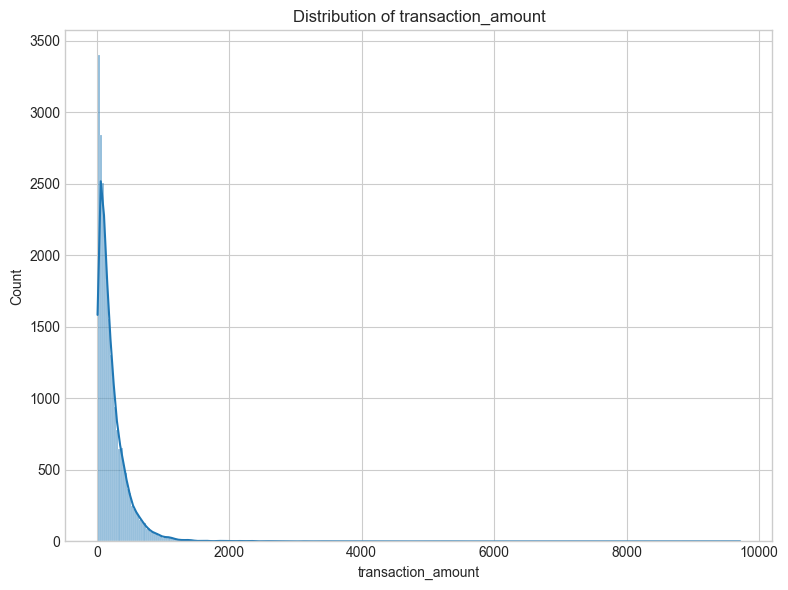

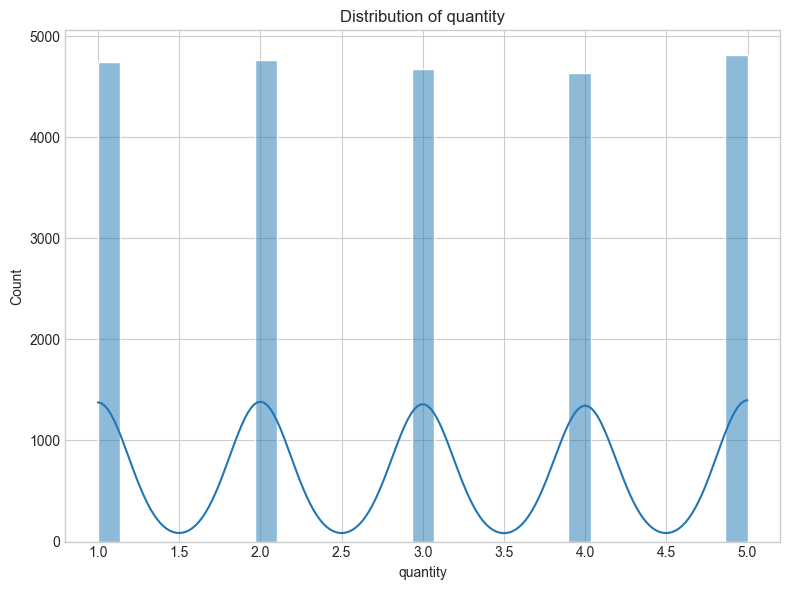

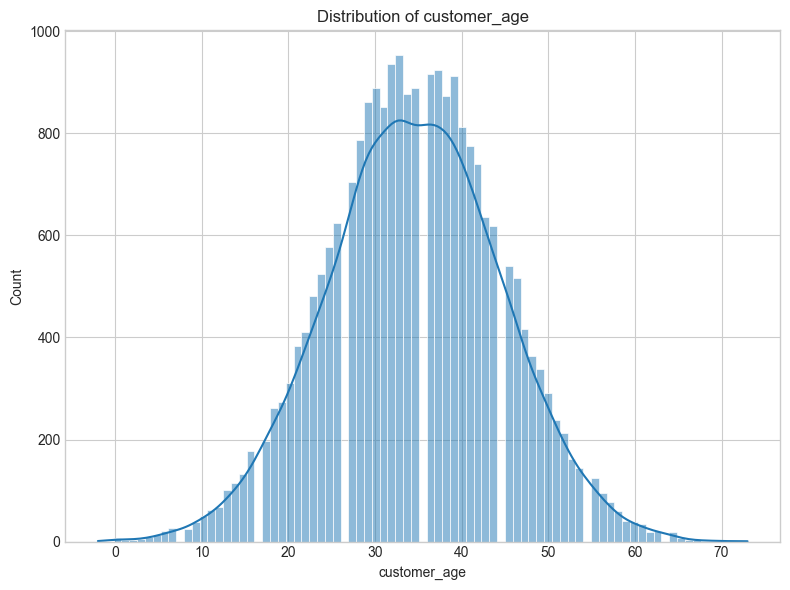

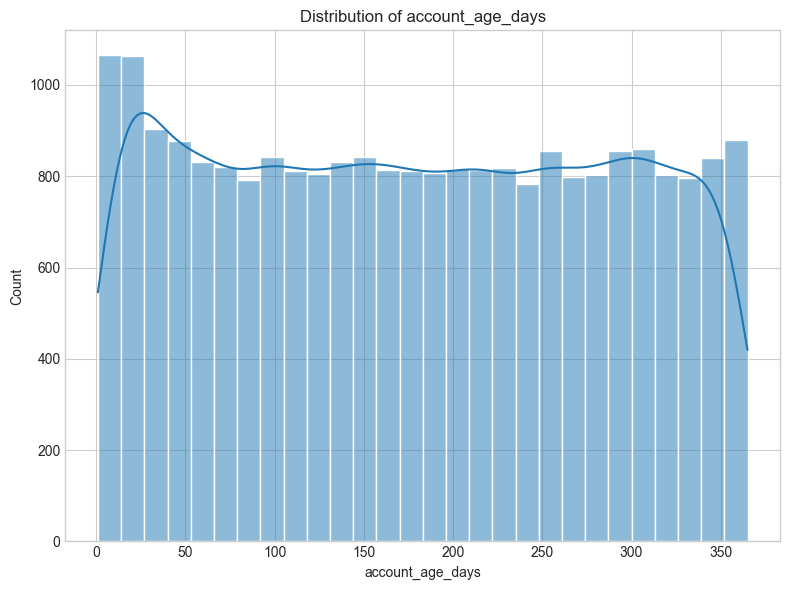

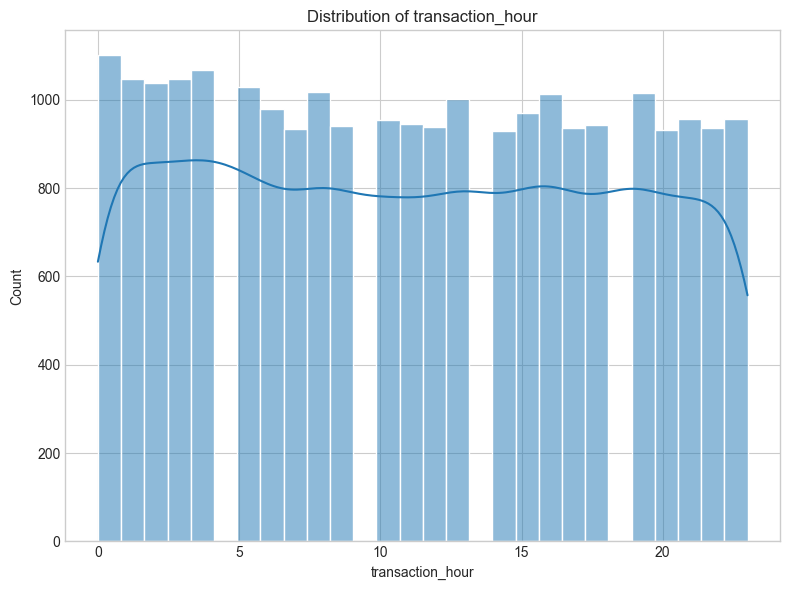

In [70]:
# Select numeric columns
numeric_cols = df_eda.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Plot distributions
for col in numeric_cols:
    if col == 'is_fraudulent':
        continue
    plt.figure(figsize=(8, 6))
    sns.histplot(df_eda[col], kde=True)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


Insight: The transaction amounts are heavily right-skewed, with the vast majority of transactions being of low value. This is typical for e-commerce data. For some machine learning models (like linear regression or models that assume normality), applying a log transformation to this feature can improve performance.

## Analyzing Temporal Patterns

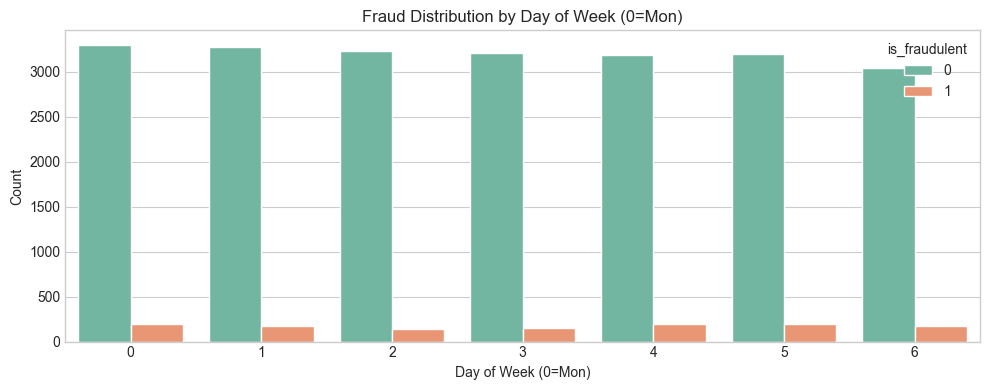

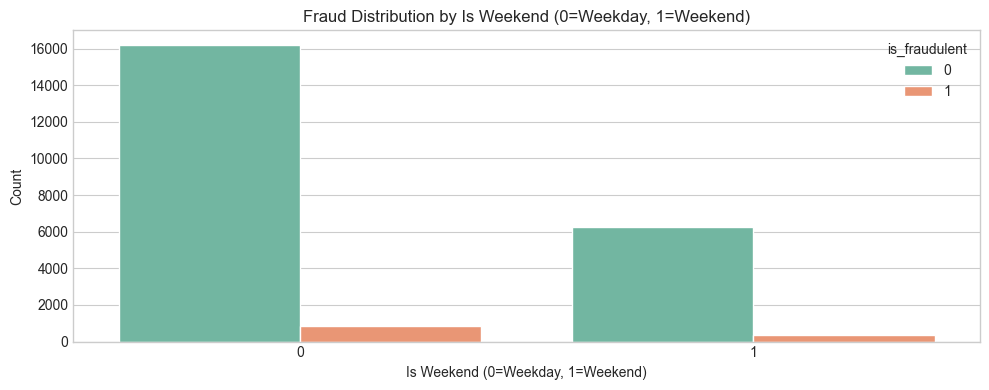

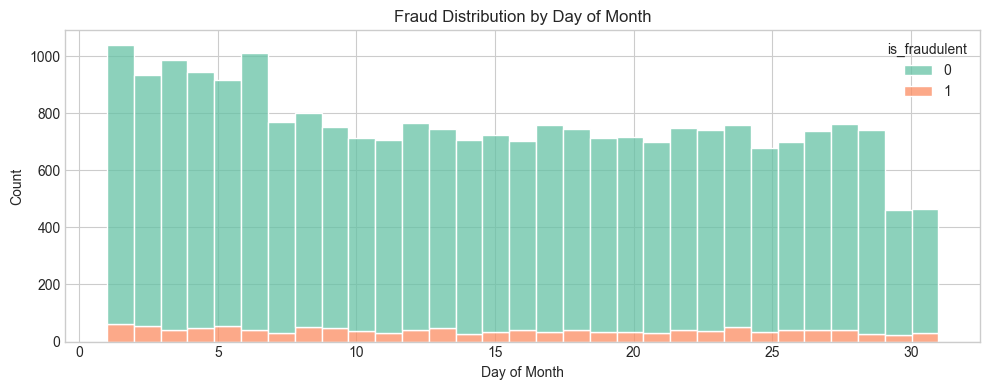

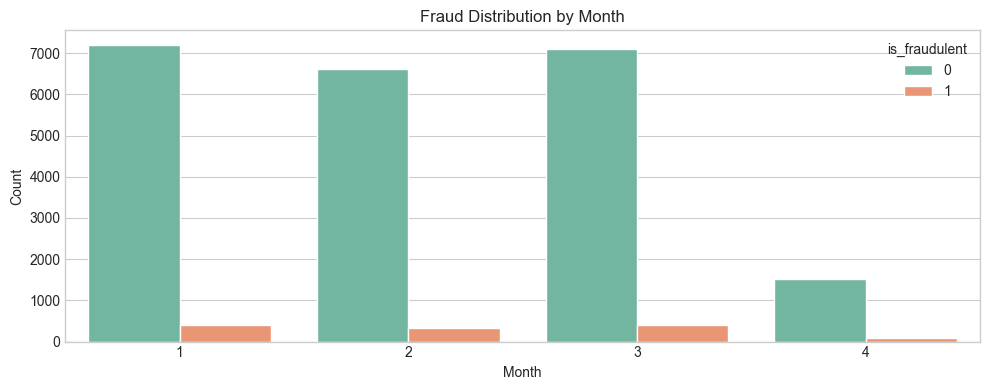

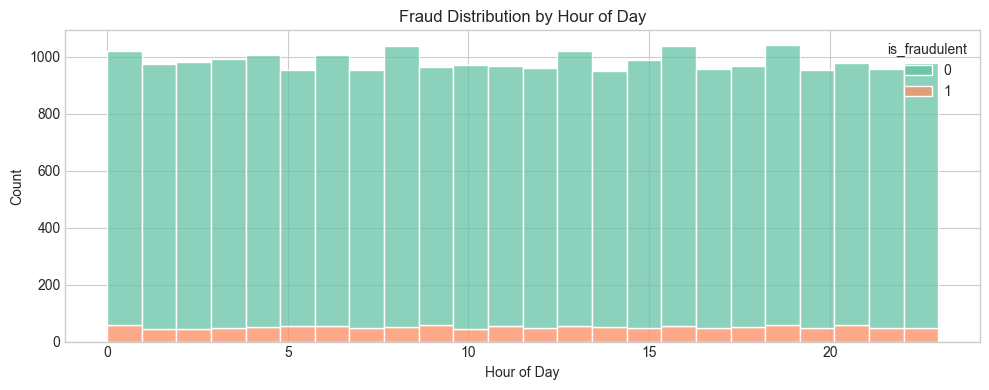

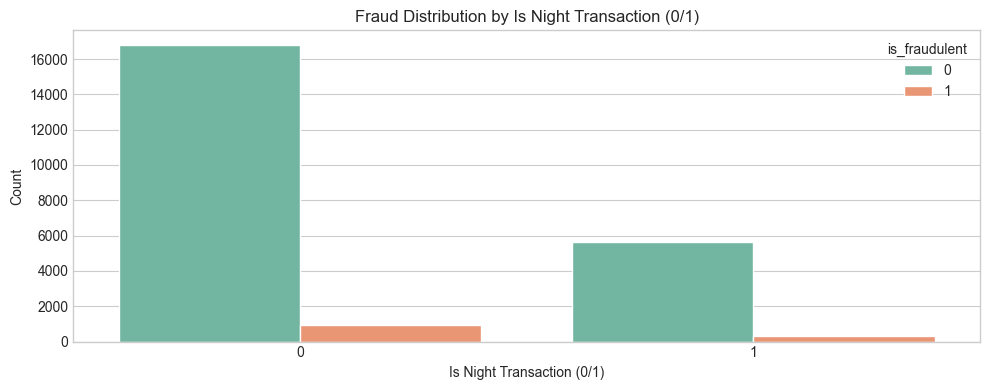


 Numerical Summary for day_of_week 
 day_of_week  fraud_rate  count  percentage
           0      0.0546   3482       14.73
           1      0.0508   3442       14.56
           2      0.0429   3378       14.29
           3      0.0453   3358       14.21
           4      0.0589   3380       14.30
           5      0.0564   3388       14.34
           6      0.0530   3206       13.57

 Numerical Summary for is_weekend 
 is_weekend  fraud_rate  count  percentage
          0      0.0505  17040        72.1
          1      0.0547   6594        27.9

 Numerical Summary for transaction_day 
 transaction_day  fraud_rate  count  percentage
               1      0.0597   1038        4.39
               2      0.0567    935        3.96
               3      0.0426    986        4.17
               4      0.0519    944        3.99
               5      0.0590    916        3.88
               6      0.0406   1011        4.28
               7      0.0403    770        3.26
               8     

In [71]:
def analyze_temporal_patterns(data, target_col='is_fraudulent'):
    """
    Extracts temporal features and produces 7 visualizations — one per feature.
    """

    # Ensure datetime
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])

    # --- Extract Temporal Features ---
    data['day_of_week'] = data['transaction_date'].dt.weekday
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    data['transaction_day'] = data['transaction_date'].dt.day
    data['transaction_month'] = data['transaction_date'].dt.month
    data['hour_of_day'] = data['transaction_date'].dt.hour
    data['is_night_transaction'] = data['hour_of_day'].isin([0,1,2,3,4,5]).astype(int)

    # Features to plot
    features = {
        "day_of_week": "Day of Week (0=Mon)",
        "is_weekend": "Is Weekend (0=Weekday, 1=Weekend)",
        "transaction_day": "Day of Month",
        "transaction_month": "Month",
        "hour_of_day": "Hour of Day",
        "is_night_transaction": "Is Night Transaction (0/1)"
    }

    # --- Plot each feature ---
    for col, title in features.items():
        plt.figure(figsize=(10,4))

        # Use histplot for features with many unique values
        if data[col].nunique() > 10:
            sns.histplot(data=data, x=col, hue='is_fraudulent',
                        multiple='stack', bins=data[col].nunique(), palette='Set2')
        else:
            sns.countplot(data=data, x=col, hue='is_fraudulent', palette='Set2')

        plt.title(f"Fraud Distribution by {title}")
        plt.xlabel(title)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # --- Numerical Summary Tables ---
    summary_tables = {}

    for col in features.keys():
        summary = (
            data
            .groupby(col)['is_fraudulent']
            .agg(
                fraud_rate='mean',
                count='count'
            )
            .reset_index()
        )
        summary['percentage'] = (summary['count'] / len(data) * 100).round(2)
        summary['fraud_rate'] = summary['fraud_rate'].round(4)

        summary_tables[col] = summary

        print("\n=====================================")
        print(f" Numerical Summary for {col} ")
        print("=====================================")
        print(summary.to_string(index=False))


analyze_temporal_patterns(df_eda, target_col='is_fraudulent')

Insight: Fraudulent transactions appear fairly evenly distributed across days, hours, and months, but several subtle temporal patterns do emerge.

Day of Week: Fraud rates fluctuate mildly, with slightly elevated levels on Thursdays (0.0589), Saturdays (0.0564), and Mondays (0.0546). However, the variation is small, indicating no strong weekday-specific fraud pattern.

Weekend vs Weekday: Weekends show a slightly higher fraud rate (0.0547 vs 0.0505), suggesting increased fraud activity but not a dramatic shift.

Day of Month: Certain dates—including the 1st, 5th, 8th, 9th, 13th, 24th, and 31st—show moderately higher fraud rates. However, these spikes do not form a consistent pattern across months.

Month: Fraud is relatively stable across January–March (0.049–0.054). The lower fraud rate in April (0.0488) appears driven by a smaller sample size rather than true behavior.

Hour of Day: Fraud rates remain consistent across hours, with slightly higher activity around 0:00, 5:00, 9:00, 11:00, 19:00, and 21:00, though differences are marginal.

Night vs Day: Night transactions have similar fraud rates to daytime transactions (0.0509 vs 0.0520), indicating no meaningful night-time fraud spike.

Overall Insight:
Temporal features show weak but measurable signals — none of the time-based variables appear strong standalone predictors, but their small variations (e.g., weekday effects, certain days of month, slight weekend lift) can still contribute incremental predictive value when combined with customer, transactional, or behavioral features in a machine learning model.

## Analyzing Categorical Features

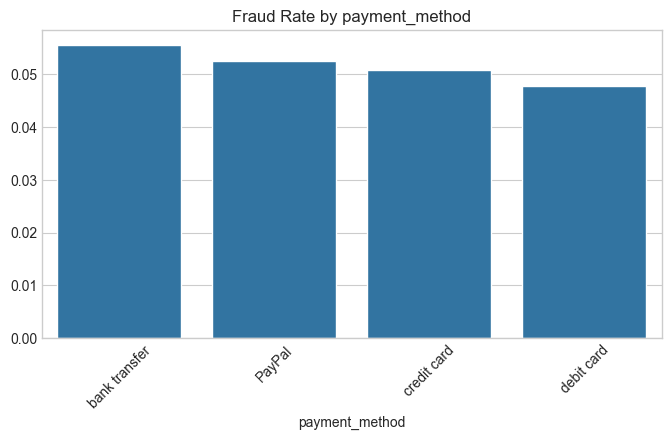

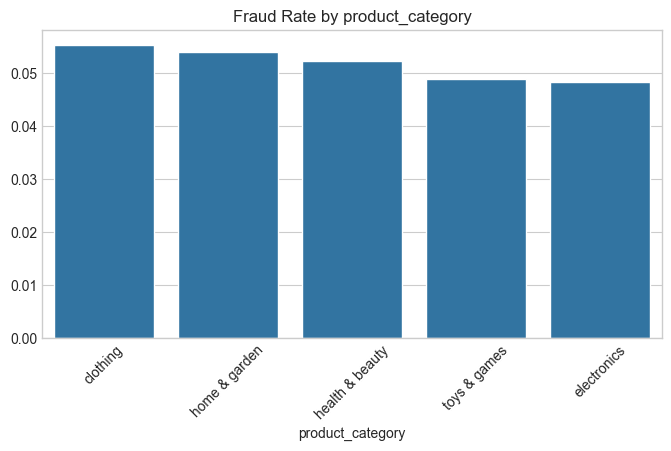

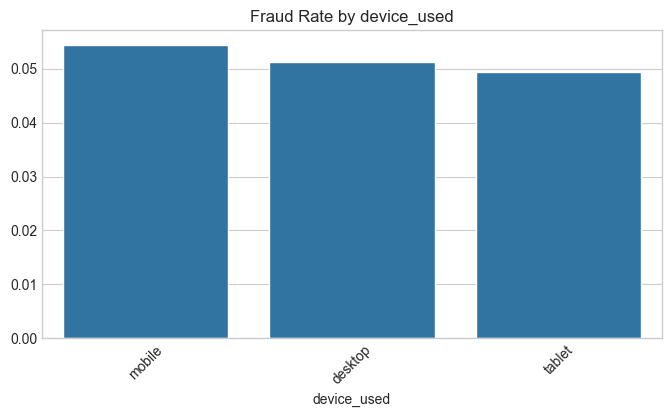

In [72]:
# Analyze fraud rates across categorical features
categorical_cols = ['payment_method', 'product_category', 'device_used']

for col in categorical_cols:
    fraud_rate = df_eda.groupby(col)['is_fraudulent'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=fraud_rate.index, y=fraud_rate.values)
    plt.title(f"Fraud Rate by {col}")
    plt.xticks(rotation=45)
    plt.show()

Insight: The fraud rate is remarkably consistent (around 5%) across all categories for these features. For example, using a 'bank transfer' isn't significantly more or less risky than using a 'credit card'. This means these features, in their current form, have low predictive power on their own. However, they could still be useful in combination with other features (e.g., a high-value 'electronics' purchase on a 'mobile' device).

## Analyzing Customer Demographics

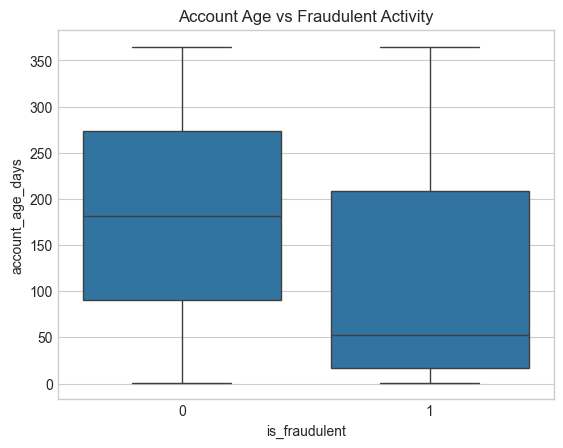

In [73]:
# Customer demographics analysis
sns.boxplot(x='is_fraudulent', y='account_age_days', data=df_eda)
plt.title("Account Age vs Fraudulent Activity")
plt.show()

Insight: This is a very strong signal. Fraudulent activity is heavily concentrated in newer accounts. The median account age for fraudulent transactions is significantly lower than for non-fraudulent ones. This is a classic fraud pattern: fraudsters create new accounts to burn before they get caught. account_age_days will be a crucial feature.

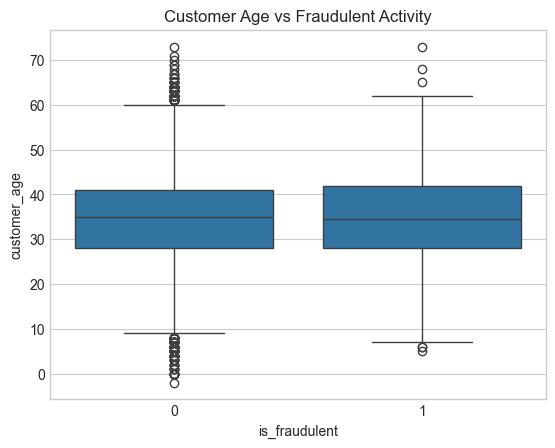

In [74]:
sns.boxplot(x='is_fraudulent', y='customer_age', data=df_eda)
plt.title("Customer Age vs Fraudulent Activity")
plt.show()

Insight: Unlike account age, the customer's actual age shows almost no difference between fraudulent and non-fraudulent transactions. The distributions are nearly identical. This feature is likely to have very low predictive power.

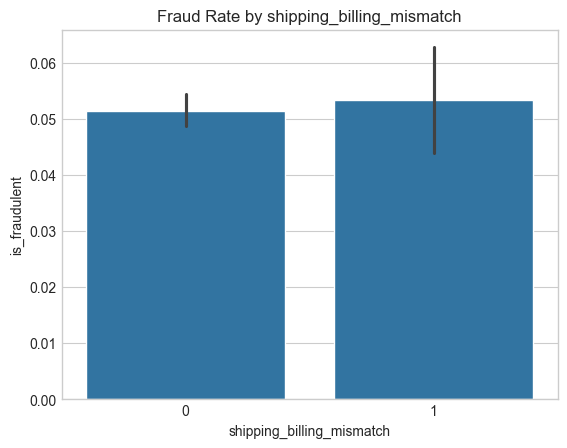

In [75]:
# Address mismatch analysis
df_eda['shipping_billing_mismatch'] = (df_eda['shipping_address'] != df_eda['billing_address']).astype(int)
sns.barplot(x='shipping_billing_mismatch', y='is_fraudulent', data=df_eda)
plt.title("Fraud Rate by shipping_billing_mismatch")
plt.show()

Insight: An address mismatch does not significantly increase the fraud rate in this dataset. This is somewhat surprising, as it's often a red flag. It could be that many legitimate customers (e.g., those sending gifts) have mismatches, diluting the signal from fraudsters.

## Correlation Between Numeric Features

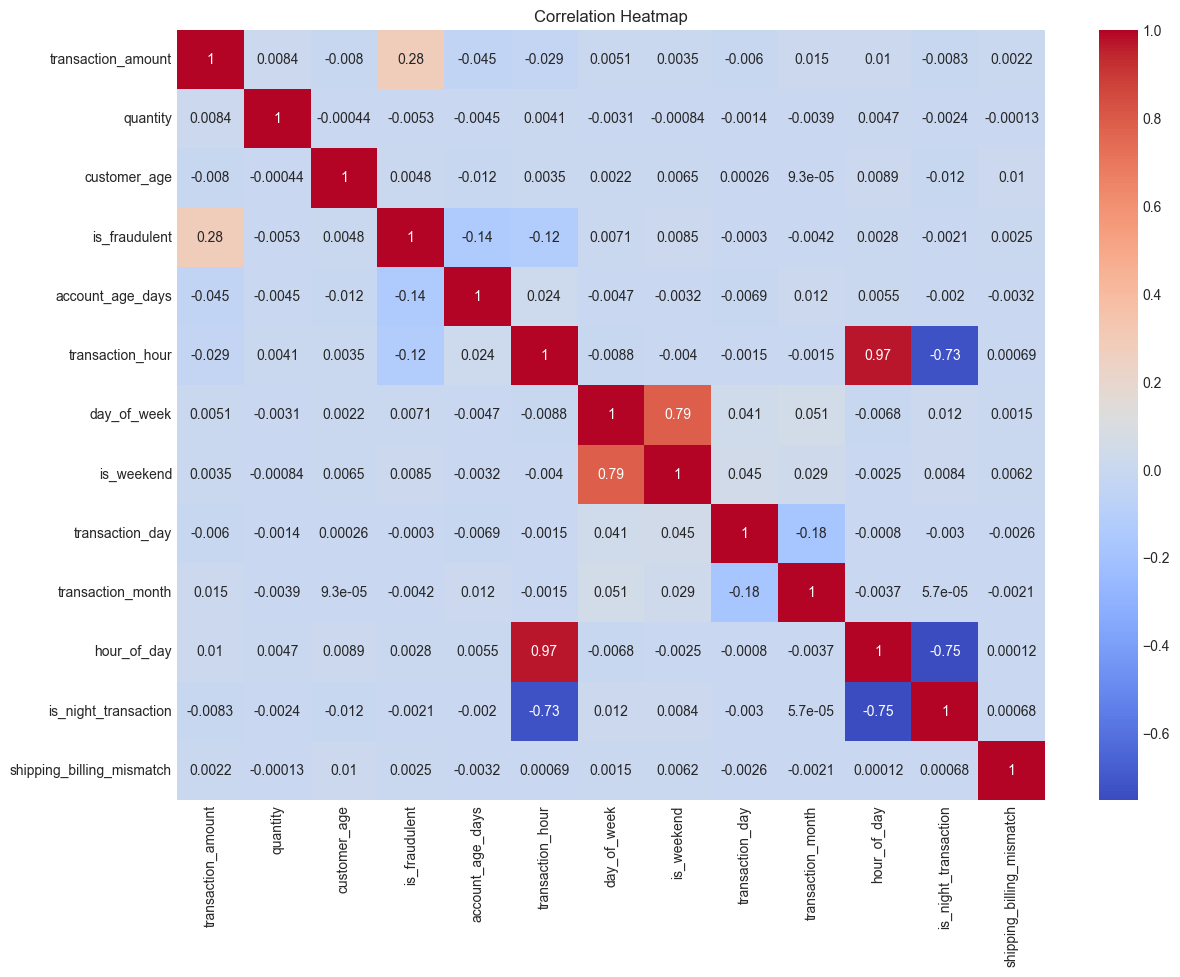

In [76]:
# Correlation analysis
numeric_cols = df_eda.select_dtypes(include=['int','float']).columns.tolist()
corr = df_eda[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Insight: The heatmap confirms the previous findings numerically. hour_of_day has the strongest positive linear correlation (0.28) with fraud, and account_age_days has the strongest negative correlation (-0.14) followed by transaction_hour (-0.12). The other numeric features have near-zero correlation, indicating little to no linear relationship with fraud.

## Importance of categorical variables with target variable

In [77]:
def categorical_target_association(df_eda, target_col):
    results = []

    # Select categorical columns (exclude ID-like ones)
    categorical_cols = df_eda.select_dtypes(include=['object', 'category']).columns
    print(categorical_cols)

    for col in categorical_cols:
        # Skip columns that are unique identifiers
        if df_eda[col].nunique() > 50:
            continue
        
        unique_vals = df_eda[col].nunique()
        target = df_eda[target_col]
        
        # Binary categorical → use t-test
        if unique_vals == 2:
            groups = []
            for val in df_eda[col].unique():
                groups.append(target[df_eda[col] == val])
            
            t_stat, p_val = ttest_ind(groups[0], groups[1], equal_var=False)
            test_type = 't-test'
        
        # Multi-category → use chi-squared test
        else:
            contingency = pd.crosstab(df_eda[col], target)
            chi2, p_val, dof, expected = chi2_contingency(contingency)
            test_type = 'chi-square'
        
        results.append({
            'Feature': col,
            'Unique Values': unique_vals,
            'Test': test_type,
            'p-value': p_val
        })

    results_df = pd.DataFrame(results)
    results_df['Significant (p<0.05)'] = results_df['p-value'] < 0.05
    return results_df.sort_values('p-value')

results = categorical_target_association(df_eda, 'is_fraudulent')
print(results)

Index(['transaction_id', 'customer_id', 'payment_method', 'product_category',
       'customer_location', 'device_used', 'ip_address', 'shipping_address',
       'billing_address'],
      dtype='object')
            Feature  Unique Values        Test   p-value  Significant (p<0.05)
0    payment_method              4  chi-square  0.284269                 False
2       device_used              3  chi-square  0.356638                 False
1  product_category              5  chi-square  0.444859                 False


Insight: The Chi Square analysis showed that there is no statistical significance between the categorical variables and target variable as all p-values are above 0.05. This indicates that these features alone do not strongly differentiate between fraud and legitimate transactions. There is a need to combine these categorical features with other features.

## Benford's Law Analysis


--- Benford's Law Analysis on 'Transaction Amount' ---
Displaying Benford's Law plot. Close the plot window to continue the script...


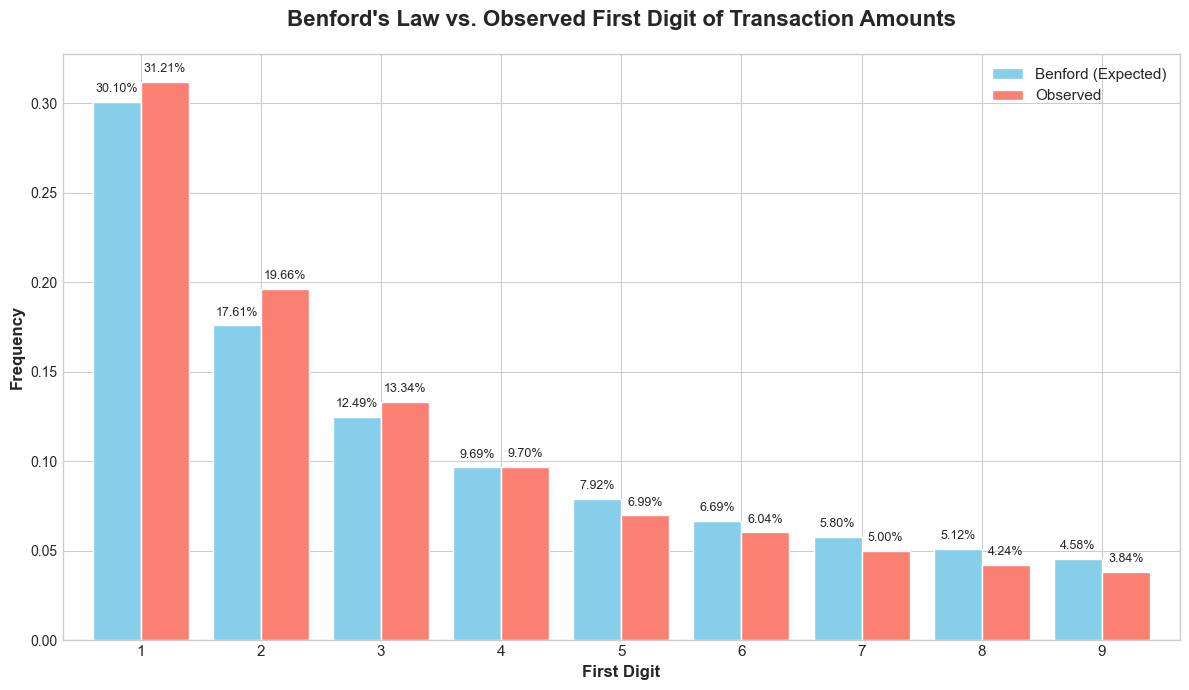

In [78]:
def benfords_law_analysis(data, column, title):
    """
    Performs Benford's Law analysis and displays the plot.
    The script will pause here until you close the plot window.
    """
    print(f"\n--- Benford's Law Analysis on '{title}' ---")
    
    # 1. Isolate the first digit
    first_digits = data[column][data[column] > 0].astype(str).str[0].astype(int)
    
    # 2. Calculate observed frequency
    observed_freq = first_digits.value_counts(normalize=True).sort_index()
    
    # 3. Calculate expected Benford frequency
    benford_digits = np.arange(1, 10)
    expected_freq = np.log10(1 + 1/benford_digits)
    
    # 4. Create a DataFrame for plotting
    analysis_df = pd.DataFrame({
        'Digit': benford_digits,
        'Benford (Expected)': expected_freq
    }).set_index('Digit')
    analysis_df = analysis_df.join(observed_freq.rename('Observed')).fillna(0)

    # 5. Generate and style the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    analysis_df.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'salmon'])
    
    ax.set_title("Benford's Law vs. Observed First Digit of Transaction Amounts", fontsize=16, pad=20, weight='bold')
    ax.set_xlabel("First Digit", fontsize=12, weight='bold')
    ax.set_ylabel("Frequency", fontsize=12, weight='bold')
    ax.tick_params(axis='x', rotation=0, labelsize=11)
    ax.legend(fontsize=11)
    
    # Add percentage labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)

    plt.tight_layout()
    
    # 6. Display the plot. The script will pause here.
    print("Displaying Benford's Law plot. Close the plot window to continue the script...")
    plt.show()

# Call the function to display the plot
benfords_law_analysis(df_eda, 'transaction_amount', 'Transaction Amount')

# More indepth EDA

## Are high-value fraudulent transactions more common in specific product categories?

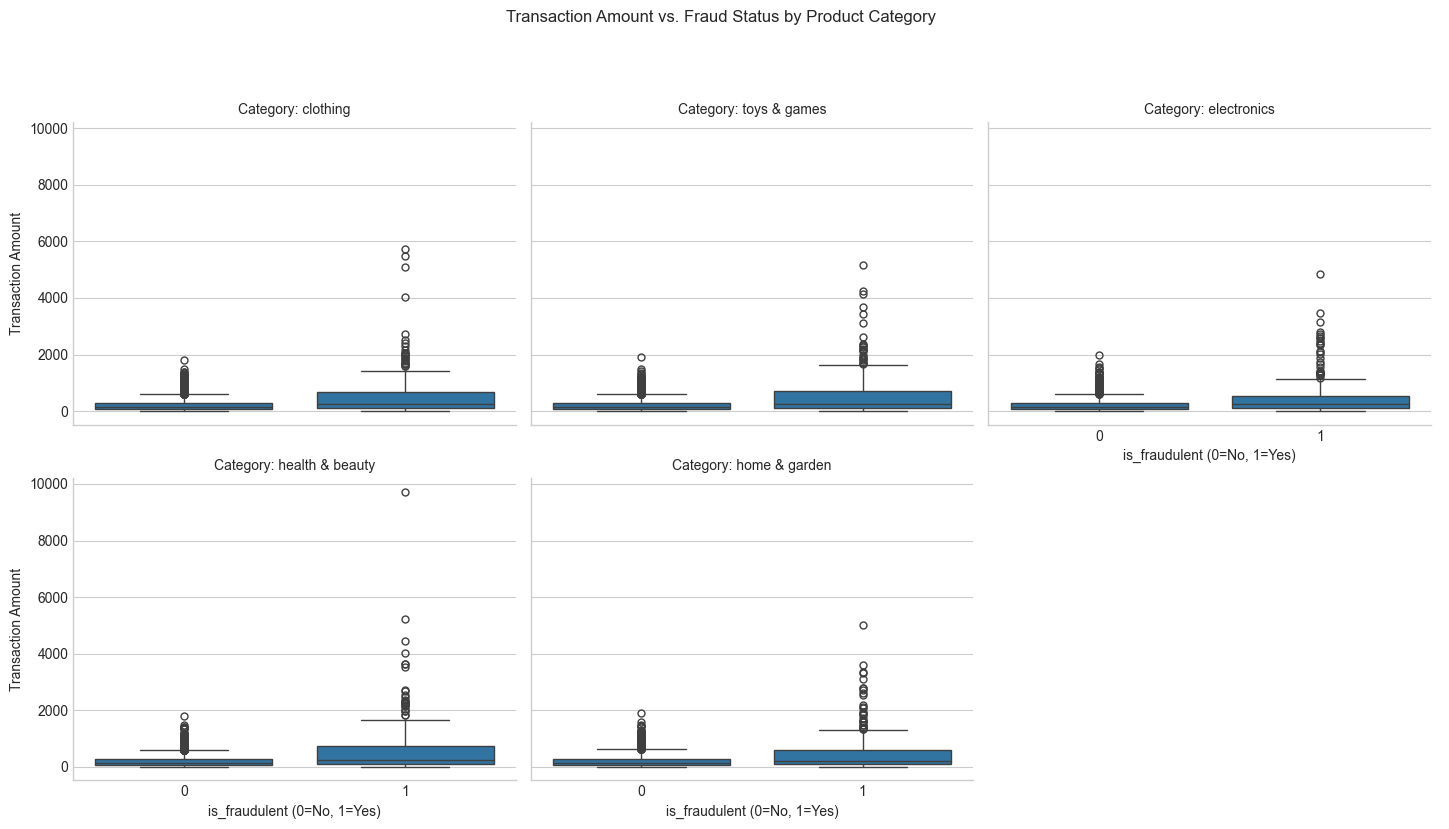

In [79]:
# Create a faceted boxplot
g = sns.catplot(
    x='is_fraudulent', 
    y='transaction_amount', 
    col='product_category', 
    data=df_eda, 
    kind='box',
    col_wrap=3, # Wraps the plots into 3 columns
    height=4,
    aspect=1.2
)

# Set titles and labels for clarity
g.fig.suptitle('Transaction Amount vs. Fraud Status by Product Category', y=1.03)
g.set_axis_labels("is_fraudulent (0=No, 1=Yes)", "Transaction Amount")
g.set_titles("Category: {col_name}")

# To prevent clipping of the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Insight: The general pattern holds true across all categories: fraudulent transactions (1) have a higher median amount and significantly more high-value outliers than non-fraudulent transactions (0).

## How many unique IPs/Addresses does a customer use? (Fraud rings)

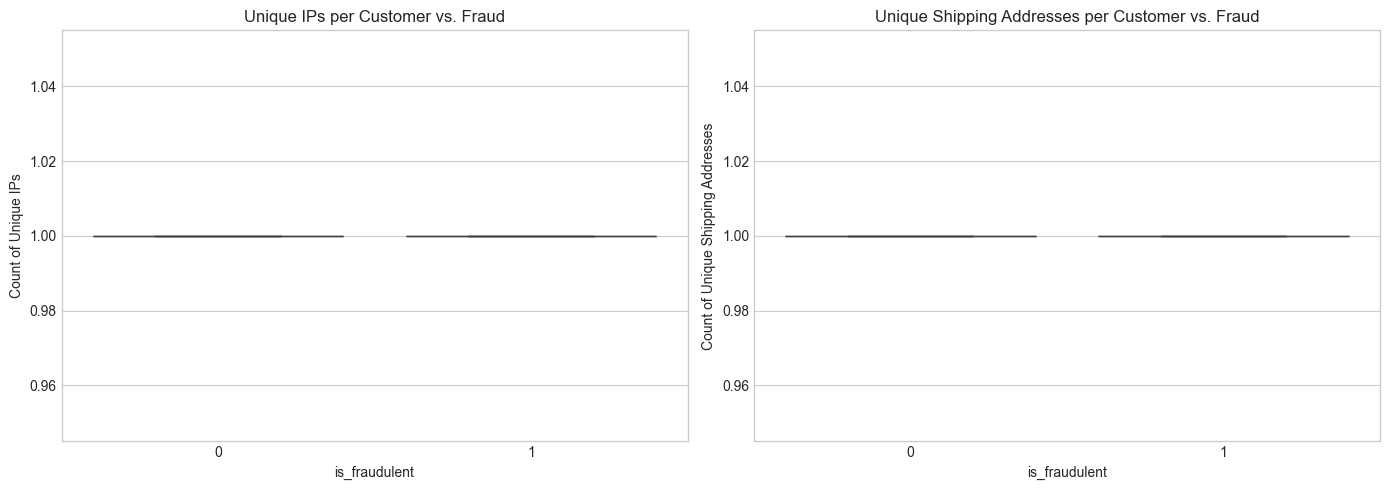

In [80]:
# Group by Customer ID and count unique IPs and Shipping Addresses
customer_behavior = df_eda.groupby('customer_id').agg(
    unique_ips_per_customer=pd.NamedAgg(column='ip_address', aggfunc='nunique'),
    unique_shipping_add_per_customer=pd.NamedAgg(column='shipping_address', aggfunc='nunique')
).reset_index()

# Merge this back into the main dataframe
df_eda = pd.merge(df_eda, customer_behavior, on='customer_id', how='left')

# Visualize the findings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x='is_fraudulent', y='unique_ips_per_customer', data=df_eda, ax=axes[0])
axes[0].set_title('Unique IPs per Customer vs. Fraud')
axes[0].set_ylabel('Count of Unique IPs')

sns.boxplot(x='is_fraudulent', y='unique_shipping_add_per_customer', data=df_eda, ax=axes[1])
axes[1].set_title('Unique Shipping Addresses per Customer vs. Fraud')
axes[1].set_ylabel('Count of Unique Shipping Addresses')

plt.tight_layout()
plt.show()

Insight: Every customer has exactly one unique IP and one unique shipping address, and consequently, no IP addresses are ever shared.
This is completely unrealistic and is the strongest evidence yet that this is a heavily sanitized or synthetic dataset. In the real world, customers use multiple devices (phone, work PC, home laptop) and send gifts to different addresses. Fraud rings are often identified by many accounts using the same IP. 

## Compare a customer's current transaction to their own past behavior.

/var/folders/wp/6lr6qb7j2bv096grzncp2yyh0000gn/T/ipykernel_42132/3646768960.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_eda['customer_avg_spend_before_tx'].fillna(0, inplace=True)


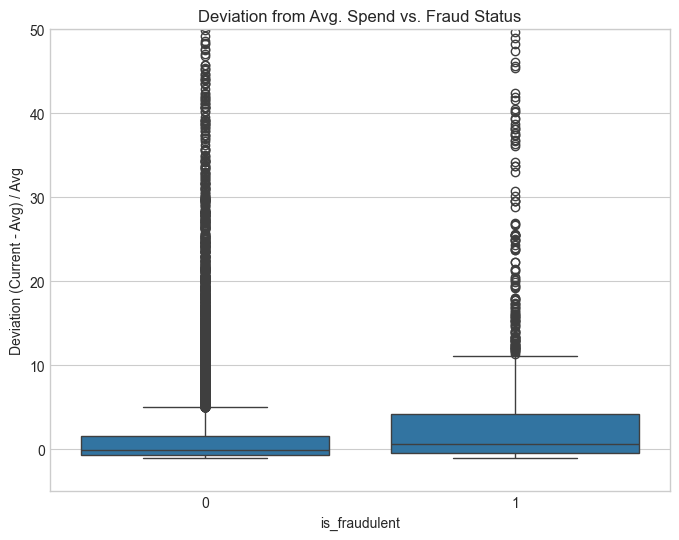

In [81]:
# Calculate a customer's expanding average spend *before* the current transaction
# shift(1) is crucial to prevent data leakage (using the current transaction's value in its own historical average)
df_eda['customer_avg_spend_before_tx'] = df_eda.groupby('customer_id')['transaction_amount'] \
                                           .expanding(min_periods=1).mean().shift(1) \
                                           .reset_index(level=0, drop=True)

# Fill NaN for the very first transaction of each customer
df_eda['customer_avg_spend_before_tx'].fillna(0, inplace=True)

# Create the deviation feature
# Add a small epsilon (1) to the denominator to avoid division by zero for the first transaction
df_eda['amount_deviation'] = (df_eda['transaction_amount'] - df_eda['customer_avg_spend_before_tx']) / (df_eda['customer_avg_spend_before_tx'] + 1)

# Visualize the deviation
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_fraudulent', y='amount_deviation', data=df_eda)
plt.title('Deviation from Avg. Spend vs. Fraud Status')
plt.ylabel('Deviation (Current - Avg) / Avg')
# Outliers can skew the plot, so let's limit the y-axis for better visibility
plt.ylim(-5, 50) 
plt.show()

Insight: amount_deviation is likely to be one of the most important predictors. It successfully captures a core behavioral dynamic of fraud as the separation between the two classes is visually very clear.

# Feature Engineering

In [82]:
# --- ELITE & LEAKAGE-PROOF FEATURE ENGINEERING ---
df['hour_of_day'] = df['transaction_date'].dt.hour
df['day_of_week'] = df['transaction_date'].dt.dayofweek
df['is_night_transaction'] = df['hour_of_day'].isin([0, 1, 2, 3, 4, 5]).astype(int)
df['shipping_billing_mismatch'] = (df['shipping_address'] != df['billing_address']).astype(int)

df['time_since_last_transaction'] = df.groupby('customer_id')['transaction_date'].diff().dt.total_seconds()
df['avg_customer_trans_amount_rolling'] = df.groupby('customer_id')['transaction_amount'].shift(1).expanding().mean()
df['customer_trans_count_rolling'] = df.groupby('customer_id').cumcount()

df_time_indexed = df.set_index('transaction_date')
df['trans_count_last_1h'] = df_time_indexed.groupby('customer_id')['transaction_id'].rolling('1H').count().values
df['trans_count_last_24h'] = df_time_indexed.groupby('customer_id')['transaction_id'].rolling('24H').count().values

df['ip_frequency'] = df.groupby('ip_address')['ip_address'].transform('count')
df['location_frequency'] = df.groupby('customer_location')['customer_location'].transform('count')

# Calculate category average amount ONCE and store it for reuse
df['category_avg_amount'] = df.groupby('product_category')['transaction_amount'].transform('mean')
df['amount_vs_category_avg'] = df['transaction_amount'] / (df['category_avg_amount'] + 1e-6)
df['amount_to_account_age_ratio'] = df['transaction_amount'] / (df['account_age_days'] + 1)
df['customer_category_uniqueness'] = df.groupby('customer_id')['product_category'].transform('nunique') / (df['customer_trans_count_rolling'] + 1)
df.fillna(0, inplace=True)

# --- DATA PREPARATION FOR MODELING ---
features_to_drop = ['transaction_id', 'customer_id', 'transaction_date', 'shipping_address', 'billing_address', 'is_fraudulent',
                      'customer_location', 'ip_address', 'category_avg_amount'] # Drop helper column
X = df.drop(columns=features_to_drop)
y = df['is_fraudulent']
categorical_features = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
numerical_features = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# --- Log skewed numerical features for Logistic Regression ---
# Create a copy of X_train and X_test for Logistic Regression
X_train_lr, X_test_lr = X_train.copy(), X_test.copy()

# Log-transform transaction_amount
X_train_lr['transaction_amount'] = np.log1p(X_train_lr['transaction_amount'])
X_test_lr['transaction_amount'] = np.log1p(X_test_lr['transaction_amount'])
scaler_lr = StandardScaler()
X_train_lr[numerical_features] = scaler_lr.fit_transform(X_train_lr[numerical_features])
X_test_lr[numerical_features] = scaler_lr.transform(X_test_lr[numerical_features])


/var/folders/wp/6lr6qb7j2bv096grzncp2yyh0000gn/T/ipykernel_42132/1627224464.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['trans_count_last_1h'] = df_time_indexed.groupby('customer_id')['transaction_id'].rolling('1H').count().values
/var/folders/wp/6lr6qb7j2bv096grzncp2yyh0000gn/T/ipykernel_42132/1627224464.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['trans_count_last_24h'] = df_time_indexed.groupby('customer_id')['transaction_id'].rolling('24H').count().values


# Model Training

## Helper Functions

In [83]:
def evaluate_model(model, X_test, y_test, y_pred=None, y_proba=None, top_n_features=20, target_names=['Not Fraud', 'Fraud']):
    """
    General model evaluation: metrics, confusion matrix, and feature importance.
    
    Args:
        model : trained classifier
        X_test (pd.DataFrame): test features
        y_test (array-like): true labels
        y_pred (array-like, optional): predicted labels; if None, uses model.predict(X_test)
        y_proba (array-like, optional): predicted probabilities for positive class; if None, tries model.predict_proba
        top_n_features (int): number of top features to show in importance plot
        target_names (list): names for classification report & confusion matrix
    """
    # --- Predictions ---
    if y_pred is None:
        y_pred = model.predict(X_test)
    
    if y_proba is None:
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            y_proba = None
    
    # --- Metrics ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    if y_proba is not None:
        print("\n--- ROC AUC / AUPRC ---")
        print(f"AUPRC Score: {average_precision_score(y_test, y_proba):.4f}")
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    
    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # --- Feature Importance ---
    importance = None
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = model.coef_[0] if model.coef_.ndim > 1 else model.coef_
    
    if importance is not None:
        feature_importance_df = pd.DataFrame({
            'feature': X_test.columns,
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n_features)

        top_features = feature_importance_df['feature'].tolist()    # For potential further analysis
        plt.figure(figsize=(10,8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Top {top_n_features} Feature Importances')
        plt.show()
    return top_features

## Logistic Regression

In [84]:
# --- HYPERPARAMETER TUNING WITH OPTUNA ---
def objective(trial, X, y, random_seed):
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    
    solver = 'liblinear'
    
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight=class_weight,
        max_iter=2000,
        random_state=random_seed
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    
    score = cross_val_score(
        model, 
        X, 
        y, 
        cv=cv, 
        scoring='roc_auc', 
        n_jobs=-1
    )
    
    return score.mean()

RANDOM_SEED_OPTUNA = 42

print("Starting Hyperparameter Tuning (Optuna TPE Sampler)...")
print("Tuning 'C', 'penalty', and 'class_weight'.") 

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(
    lambda trial: objective(trial, X_train_lr, y_train, RANDOM_SEED_OPTUNA), 
    
    n_trials=100, 
    show_progress_bar=True
)
print("Tuning complete")

[I 2025-11-19 17:27:13,209] A new study created in memory with name: no-name-3b41b417-582e-4c8a-a09c-b5a943ca3963


Starting Hyperparameter Tuning (Optuna TPE Sampler)...
Tuning 'C', 'penalty', and 'class_weight'.


Best trial: 0. Best value: 0.815761:   1%|          | 1/100 [00:01<02:14,  1.35s/it]

[I 2025-11-19 17:27:14,559] Trial 0 finished with value: 0.8157607700508664 and parameters: {'C': 0.017670169402947963, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607700508664.


Best trial: 0. Best value: 0.815761:   2%|▏         | 2/100 [00:02<01:40,  1.02s/it]

[I 2025-11-19 17:27:15,356] Trial 1 finished with value: 0.7528554203037242 and parameters: {'C': 0.0008629132190071866, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.8157607700508664.


Best trial: 0. Best value: 0.815761:   3%|▎         | 3/100 [00:02<01:26,  1.12it/s]

[I 2025-11-19 17:27:16,094] Trial 2 finished with value: 0.5 and parameters: {'C': 0.00013289448722869195, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607700508664.


Best trial: 0. Best value: 0.815761:   6%|▌         | 6/100 [00:03<00:40,  2.30it/s]

[I 2025-11-19 17:27:16,857] Trial 3 finished with value: 0.8047569249355284 and parameters: {'C': 0.0012601639723276807, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607700508664.
[I 2025-11-19 17:27:16,933] Trial 4 finished with value: 0.8101340070361409 and parameters: {'C': 0.46894009635376926, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.8157607700508664.
[I 2025-11-19 17:27:17,006] Trial 5 finished with value: 0.8125692493736014 and parameters: {'C': 5.141096648805751, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607700508664.


Best trial: 0. Best value: 0.815761:   7%|▋         | 7/100 [00:04<00:37,  2.47it/s]

[I 2025-11-19 17:27:17,331] Trial 6 finished with value: 0.8092695817402913 and parameters: {'C': 0.4418441521199724, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8157607700508664.


Best trial: 0. Best value: 0.815761:  10%|█         | 10/100 [00:04<00:20,  4.33it/s]

[I 2025-11-19 17:27:17,590] Trial 7 finished with value: 0.8125626598870725 and parameters: {'C': 7.085721663941602, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607700508664.
[I 2025-11-19 17:27:17,645] Trial 8 finished with value: 0.7227444994520598 and parameters: {'C': 0.0005397956855996448, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607700508664.
[I 2025-11-19 17:27:17,722] Trial 9 finished with value: 0.812753091368396 and parameters: {'C': 0.9443515687962687, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607700508664.
[I 2025-11-19 17:27:17,787] Trial 10 finished with value: 0.8152072852553601 and parameters: {'C': 0.017654677164766083, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8157607700508664.


Best trial: 0. Best value: 0.815761:  14%|█▍        | 14/100 [00:04<00:11,  7.52it/s]

[I 2025-11-19 17:27:17,853] Trial 11 finished with value: 0.8149204211886694 and parameters: {'C': 0.012053282859112415, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8157607700508664.
[I 2025-11-19 17:27:17,932] Trial 12 finished with value: 0.8148648003188541 and parameters: {'C': 0.029852550302478284, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8157607700508664.
[I 2025-11-19 17:27:17,997] Trial 13 finished with value: 0.8152043947420351 and parameters: {'C': 0.017884029225640932, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8157607700508664.


Best trial: 14. Best value: 0.817364:  16%|█▌        | 16/100 [00:04<00:09,  9.09it/s]

[I 2025-11-19 17:27:18,064] Trial 14 finished with value: 0.8173639595265637 and parameters: {'C': 0.005189503995634191, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:18,128] Trial 15 finished with value: 0.8128495392483893 and parameters: {'C': 0.0027567634290324838, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 14. Best value: 0.817364:  16%|█▌        | 16/100 [00:05<00:09,  9.09it/s]

[I 2025-11-19 17:27:18,347] Trial 16 finished with value: 0.8136160477818131 and parameters: {'C': 0.15695998625583918, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 14. Best value: 0.817364:  20%|██        | 20/100 [00:05<00:10,  7.99it/s]

[I 2025-11-19 17:27:18,622] Trial 17 finished with value: 0.81253438072836 and parameters: {'C': 71.50594757630067, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:18,690] Trial 18 finished with value: 0.8168889686191729 and parameters: {'C': 0.004496892478162729, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:18,746] Trial 19 finished with value: 0.5 and parameters: {'C': 0.00014846584239620875, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:18,814] Trial 20 finished with value: 0.8163472333384032 and parameters: {'C': 0.0039957784782490334, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 14. Best value: 0.817364:  22%|██▏       | 22/100 [00:05<00:08,  9.27it/s]

[I 2025-11-19 17:27:18,885] Trial 21 finished with value: 0.8163654674020497 and parameters: {'C': 0.004004851160266243, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:18,958] Trial 22 finished with value: 0.8168943841256354 and parameters: {'C': 0.004504595352727639, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 14. Best value: 0.817364:  24%|██▍       | 24/100 [00:06<00:08,  9.05it/s]

[I 2025-11-19 17:27:19,118] Trial 23 finished with value: 0.8150815048901217 and parameters: {'C': 0.04694532945835238, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:19,316] Trial 24 finished with value: 0.8141120826351063 and parameters: {'C': 0.09246237229874735, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 14. Best value: 0.817364:  28%|██▊       | 28/100 [00:06<00:07, 10.16it/s]

[I 2025-11-19 17:27:19,369] Trial 25 finished with value: 0.643611666836202 and parameters: {'C': 0.00038122725014549756, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:19,435] Trial 26 finished with value: 0.8123282559229702 and parameters: {'C': 0.0045580227208641255, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:19,489] Trial 27 finished with value: 0.7846343400358633 and parameters: {'C': 0.0015035735503251522, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:19,568] Trial 28 finished with value: 0.817222283526909 and parameters: {'C': 0.008303007717285628, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 14. Best value: 0.817364:  30%|███       | 30/100 [00:06<00:06, 10.61it/s]

[I 2025-11-19 17:27:19,659] Trial 29 finished with value: 0.8164373170421598 and parameters: {'C': 0.010070161884683616, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:19,851] Trial 30 finished with value: 0.814595287702945 and parameters: {'C': 0.06601823007614402, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 14. Best value: 0.817364:  34%|███▍      | 34/100 [00:06<00:06, 10.44it/s]

[I 2025-11-19 17:27:19,930] Trial 31 finished with value: 0.8171834268675108 and parameters: {'C': 0.008437958898363797, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:19,985] Trial 32 finished with value: 0.7926837665626769 and parameters: {'C': 0.0016246402258474398, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:20,071] Trial 33 finished with value: 0.816995491072257 and parameters: {'C': 0.008934790384336545, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 14. Best value: 0.817364:  36%|███▌      | 36/100 [00:07<00:05, 11.42it/s]

[I 2025-11-19 17:27:20,149] Trial 34 finished with value: 0.8141443825708343 and parameters: {'C': 0.009897123689670027, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:20,208] Trial 35 finished with value: 0.7285452811965929 and parameters: {'C': 0.000552827458928428, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:20,286] Trial 36 finished with value: 0.8135150994841165 and parameters: {'C': 0.17258295967133172, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 14. Best value: 0.817364:  40%|████      | 40/100 [00:07<00:05, 11.80it/s]

[I 2025-11-19 17:27:20,439] Trial 37 finished with value: 0.815699087472068 and parameters: {'C': 0.02790970706718356, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:20,490] Trial 38 finished with value: 0.5 and parameters: {'C': 0.00018163732495379676, 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:20,556] Trial 39 finished with value: 0.8077730585909567 and parameters: {'C': 0.0018586181499453836, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.
[I 2025-11-19 17:27:20,612] Trial 40 finished with value: 0.7709565218883736 and parameters: {'C': 0.0008770009240626558, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.8173639595265637.


Best trial: 41. Best value: 0.817491:  42%|████▏     | 42/100 [00:07<00:04, 12.67it/s]

[I 2025-11-19 17:27:20,687] Trial 41 finished with value: 0.817491285473273 and parameters: {'C': 0.007275977780221469, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 41 with value: 0.817491285473273.
[I 2025-11-19 17:27:20,767] Trial 42 finished with value: 0.8172476943296602 and parameters: {'C': 0.008255207121439147, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 41 with value: 0.817491285473273.


Best trial: 41. Best value: 0.817491:  46%|████▌     | 46/100 [00:07<00:04, 10.91it/s]

[I 2025-11-19 17:27:20,914] Trial 43 finished with value: 0.8153065387619787 and parameters: {'C': 0.03943164521606497, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 41 with value: 0.817491285473273.
[I 2025-11-19 17:27:21,043] Trial 44 finished with value: 0.8158004097767904 and parameters: {'C': 0.02195788155756717, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 41 with value: 0.817491285473273.
[I 2025-11-19 17:27:21,108] Trial 45 finished with value: 0.8126424132952577 and parameters: {'C': 0.007571817549556701, 'penalty': 'l1', 'class_weight': None}. Best is trial 41 with value: 0.817491285473273.


Best trial: 41. Best value: 0.817491:  48%|████▊     | 48/100 [00:08<00:05,  8.99it/s]

[I 2025-11-19 17:27:21,353] Trial 46 finished with value: 0.8134274221531417 and parameters: {'C': 0.2056131660986093, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 41 with value: 0.817491285473273.
[I 2025-11-19 17:27:21,422] Trial 47 finished with value: 0.8096821872976168 and parameters: {'C': 0.002536523096340679, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 41 with value: 0.817491285473273.


Best trial: 41. Best value: 0.817491:  50%|█████     | 50/100 [00:08<00:07,  6.47it/s]

[I 2025-11-19 17:27:21,876] Trial 48 finished with value: 0.8077101512698086 and parameters: {'C': 1.5985810779564942, 'penalty': 'l1', 'class_weight': None}. Best is trial 41 with value: 0.817491285473273.
[I 2025-11-19 17:27:21,932] Trial 49 finished with value: 0.77110822522179 and parameters: {'C': 0.0008846344931599374, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 41 with value: 0.817491285473273.
[I 2025-11-19 17:27:22,023] Trial 50 finished with value: 0.8157069796089008 and parameters: {'C': 0.012399549172104583, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 41 with value: 0.817491285473273.


Best trial: 52. Best value: 0.817513:  54%|█████▍    | 54/100 [00:09<00:05,  8.12it/s]

[I 2025-11-19 17:27:22,112] Trial 51 finished with value: 0.8170628694613015 and parameters: {'C': 0.008746486915814049, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 41 with value: 0.817491285473273.
[I 2025-11-19 17:27:22,191] Trial 52 finished with value: 0.8175125637291799 and parameters: {'C': 0.007110880785993971, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.8175125637291799.
[I 2025-11-19 17:27:22,303] Trial 53 finished with value: 0.8157801473648985 and parameters: {'C': 0.01841760167385893, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.8175125637291799.


Best trial: 52. Best value: 0.817513:  56%|█████▌    | 56/100 [00:09<00:05,  8.03it/s]

[I 2025-11-19 17:27:22,371] Trial 54 finished with value: 0.8118719255886425 and parameters: {'C': 0.002584586974648268, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.8175125637291799.
[I 2025-11-19 17:27:22,558] Trial 55 finished with value: 0.8148086243609696 and parameters: {'C': 0.056171233207673366, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 52 with value: 0.8175125637291799.


Best trial: 56. Best value: 0.817597:  58%|█████▊    | 58/100 [00:09<00:04,  9.03it/s]

[I 2025-11-19 17:27:22,637] Trial 56 finished with value: 0.8175966977319018 and parameters: {'C': 0.006495945758368056, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 56 with value: 0.8175966977319018.
[I 2025-11-19 17:27:22,716] Trial 57 finished with value: 0.7888539092960452 and parameters: {'C': 0.005705339659456089, 'penalty': 'l1', 'class_weight': None}. Best is trial 56 with value: 0.8175966977319018.
[I 2025-11-19 17:27:22,818] Trial 58 finished with value: 0.8157324879980811 and parameters: {'C': 0.015585028919111758, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 56 with value: 0.8175966977319018.


Best trial: 56. Best value: 0.817597:  62%|██████▏   | 62/100 [00:09<00:03, 10.74it/s]

[I 2025-11-19 17:27:22,874] Trial 59 finished with value: 0.643611666836202 and parameters: {'C': 0.00032478353368009305, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 56 with value: 0.8175966977319018.
[I 2025-11-19 17:27:22,952] Trial 60 finished with value: 0.8125335312874322 and parameters: {'C': 45.87267911540283, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 56 with value: 0.8175966977319018.
[I 2025-11-19 17:27:23,022] Trial 61 finished with value: 0.8175751907099107 and parameters: {'C': 0.0059851306129194756, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 56 with value: 0.8175966977319018.


Best trial: 56. Best value: 0.817597:  64%|██████▍   | 64/100 [00:10<00:03, 11.67it/s]

[I 2025-11-19 17:27:23,092] Trial 62 finished with value: 0.8142339372698121 and parameters: {'C': 0.0030713514078788725, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 56 with value: 0.8175966977319018.
[I 2025-11-19 17:27:23,159] Trial 63 finished with value: 0.8175754781023409 and parameters: {'C': 0.005984649780650441, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 56 with value: 0.8175966977319018.
[I 2025-11-19 17:27:23,216] Trial 64 finished with value: 0.7741611317125345 and parameters: {'C': 0.0011506771606790297, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 56 with value: 0.8175966977319018.


Best trial: 65. Best value: 0.817604:  66%|██████▌   | 66/100 [00:10<00:02, 12.49it/s]

[I 2025-11-19 17:27:23,293] Trial 65 finished with value: 0.817604261947072 and parameters: {'C': 0.00633288581626191, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.
[I 2025-11-19 17:27:23,440] Trial 66 finished with value: 0.8155296036079793 and parameters: {'C': 0.03271740543754707, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.


Best trial: 65. Best value: 0.817604:  70%|███████   | 70/100 [00:10<00:02, 12.61it/s]

[I 2025-11-19 17:27:23,514] Trial 67 finished with value: 0.8172557300772294 and parameters: {'C': 0.004986670371513895, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.
[I 2025-11-19 17:27:23,571] Trial 68 finished with value: 0.8034498591677568 and parameters: {'C': 0.0019234782199563328, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.
[I 2025-11-19 17:27:23,626] Trial 69 finished with value: 0.7334935386348118 and parameters: {'C': 0.0030012008001227748, 'penalty': 'l1', 'class_weight': None}. Best is trial 65 with value: 0.817604261947072.
[I 2025-11-19 17:27:23,705] Trial 70 finished with value: 0.8175766266890546 and parameters: {'C': 0.005974988277655632, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.


Best trial: 65. Best value: 0.817604:  74%|███████▍  | 74/100 [00:10<00:02, 12.10it/s]

[I 2025-11-19 17:27:23,817] Trial 71 finished with value: 0.8157327544298527 and parameters: {'C': 0.014839346736329155, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.
[I 2025-11-19 17:27:23,897] Trial 72 finished with value: 0.817488764735766 and parameters: {'C': 0.005576661279376445, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.
[I 2025-11-19 17:27:23,975] Trial 73 finished with value: 0.817479091254316 and parameters: {'C': 0.005546171802606116, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.


Best trial: 65. Best value: 0.817604:  76%|███████▌  | 76/100 [00:10<00:02, 11.68it/s]

[I 2025-11-19 17:27:24,031] Trial 74 finished with value: 0.7338496870207291 and parameters: {'C': 0.0005651319442679509, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.
[I 2025-11-19 17:27:24,161] Trial 75 finished with value: 0.8157102671658281 and parameters: {'C': 0.027664184222128886, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.


Best trial: 77. Best value: 0.817606:  78%|███████▊  | 78/100 [00:11<00:01, 12.07it/s]

[I 2025-11-19 17:27:24,236] Trial 76 finished with value: 0.8154820708354824 and parameters: {'C': 0.0035008266000619626, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 65 with value: 0.817604261947072.
[I 2025-11-19 17:27:24,313] Trial 77 finished with value: 0.8176058716377529 and parameters: {'C': 0.0061559254454280465, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:24,381] Trial 78 finished with value: 0.8146879605945279 and parameters: {'C': 0.021859479822229473, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.


Best trial: 77. Best value: 0.817606:  82%|████████▏ | 82/100 [00:11<00:01, 11.36it/s]

[I 2025-11-19 17:27:24,579] Trial 79 finished with value: 0.8141574223353218 and parameters: {'C': 0.08968522902233995, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:24,635] Trial 80 finished with value: 0.7742565996435647 and parameters: {'C': 0.0011645123565249401, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:24,709] Trial 81 finished with value: 0.8175825931256462 and parameters: {'C': 0.006016316272007867, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:24,766] Trial 82 finished with value: 0.8068632165050926 and parameters: {'C': 0.00210160245586469, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.


Best trial: 77. Best value: 0.817606:  86%|████████▌ | 86/100 [00:11<00:01, 12.09it/s]

[I 2025-11-19 17:27:24,844] Trial 83 finished with value: 0.81759740419708 and parameters: {'C': 0.006355712533823133, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:24,947] Trial 84 finished with value: 0.815678229540565 and parameters: {'C': 0.012988781414966592, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:25,013] Trial 85 finished with value: 0.8161987403744249 and parameters: {'C': 0.0038838045721744374, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.


Best trial: 77. Best value: 0.817606:  90%|█████████ | 90/100 [00:12<00:00, 13.13it/s]

[I 2025-11-19 17:27:25,105] Trial 86 finished with value: 0.8158193461049356 and parameters: {'C': 0.011628410312069539, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:25,183] Trial 87 finished with value: 0.8176014666817164 and parameters: {'C': 0.006558726287123517, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:25,237] Trial 88 finished with value: 0.643611666836202 and parameters: {'C': 0.0015780428513656535, 'penalty': 'l1', 'class_weight': None}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:25,302] Trial 89 finished with value: 0.8176013578181719 and parameters: {'C': 0.00610377988166626, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.


Best trial: 77. Best value: 0.817606:  92%|█████████▏| 92/100 [00:12<00:00, 13.05it/s]

[I 2025-11-19 17:27:25,377] Trial 90 finished with value: 0.8146782316494526 and parameters: {'C': 0.022275084090828703, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:25,457] Trial 91 finished with value: 0.8175706565402345 and parameters: {'C': 0.005940458656328257, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:25,526] Trial 92 finished with value: 0.8150496574921491 and parameters: {'C': 0.0033270240016848225, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.


Best trial: 77. Best value: 0.817606:  96%|█████████▌| 96/100 [00:12<00:00, 13.13it/s]

[I 2025-11-19 17:27:25,606] Trial 93 finished with value: 0.8175587625111277 and parameters: {'C': 0.0067568167040275755, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:25,692] Trial 94 finished with value: 0.8162315415220632 and parameters: {'C': 0.010519471703600765, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:25,759] Trial 95 finished with value: 0.8110107512280971 and parameters: {'C': 0.002472205778142049, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.


Best trial: 77. Best value: 0.817606:  98%|█████████▊| 98/100 [00:12<00:00, 12.38it/s]

[I 2025-11-19 17:27:25,835] Trial 96 finished with value: 0.8166763818862653 and parameters: {'C': 0.004279441748017775, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:25,943] Trial 97 finished with value: 0.8157254648585383 and parameters: {'C': 0.015380171014572105, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.


Best trial: 77. Best value: 0.817606: 100%|██████████| 100/100 [00:12<00:00,  7.70it/s]

[I 2025-11-19 17:27:26,104] Trial 98 finished with value: 0.8151671825571437 and parameters: {'C': 0.04476387107291331, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
[I 2025-11-19 17:27:26,194] Trial 99 finished with value: 0.8160240750330189 and parameters: {'C': 0.010998782559113357, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 77 with value: 0.8176058716377529.
Tuning complete


In [85]:
# Retrieve and display the best parameters and score
best_params = study.best_params
best_roc_auc = study.best_value

best_model_lr = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    
    class_weight=best_params['class_weight'], 
    
    solver='liblinear',
    max_iter=2000,
    random_state=RANDOM_SEED_OPTUNA
)

best_model_lr.fit(X_train_lr, y_train)

print("OPTUNA TUNING RESULTS")
print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST ROC AUC SCORE (from Cross-Validation): {best_roc_auc:.4f}")

OPTUNA TUNING RESULTS
BEST PARAMETERS FOUND: {'C': 0.0061559254454280465, 'penalty': 'l1', 'class_weight': 'balanced'}
BEST ROC AUC SCORE (from Cross-Validation): 0.8176



--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.98      0.84      0.90      4483
       Fraud       0.18      0.64      0.28       244

    accuracy                           0.83      4727
   macro avg       0.58      0.74      0.59      4727
weighted avg       0.94      0.83      0.87      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.5108
ROC AUC Score: 0.8245


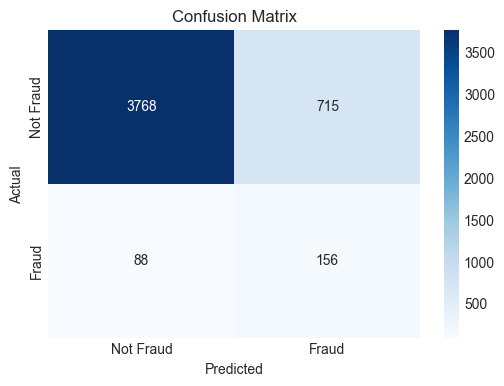

/var/folders/wp/6lr6qb7j2bv096grzncp2yyh0000gn/T/ipykernel_42132/730573742.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


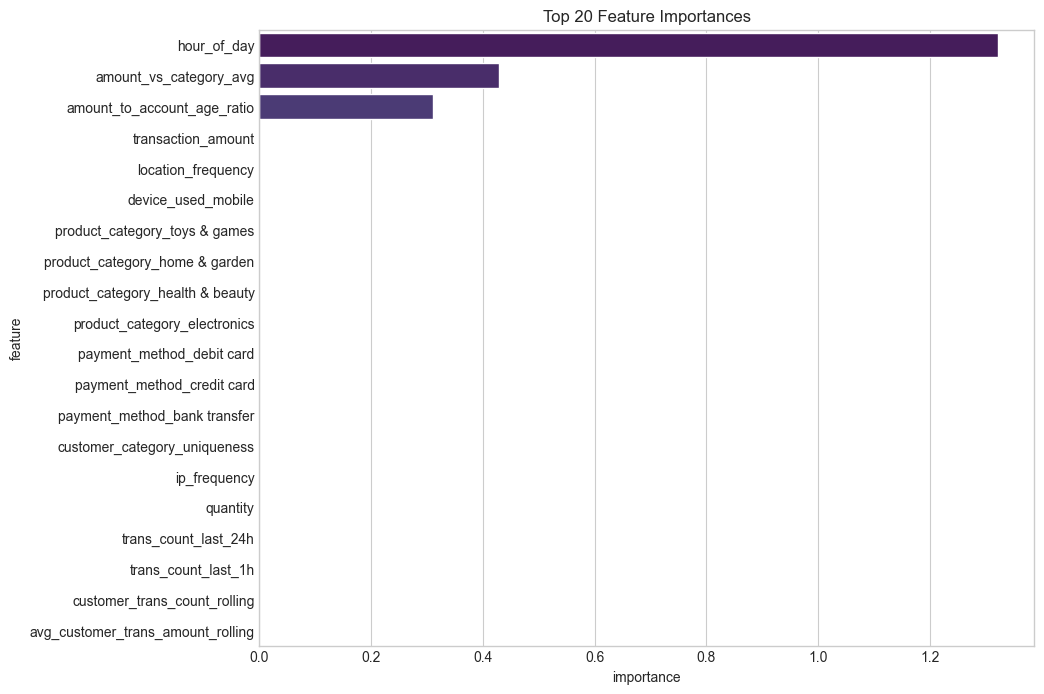

In [86]:
# --- EVALUATE THE MODEL ---
y_pred_lr = best_model_lr.predict(X_test_lr)
y_proba_lr = best_model_lr.predict_proba(X_test_lr)[:, 1]
top_features_lr = evaluate_model(best_model_lr, X_test_lr, y_test, y_pred=y_pred_lr, y_proba=y_proba_lr)

## XGBoost

In [87]:
# --- XGBOOST HYPERPARAMETER TUNING WITH OPTUNA ---
def objective(trial):
    scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)
    
    params = {
        'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42,
        'scale_pos_weight': scale_pos_weight,
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # ---- K-FOLD ----
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params, use_label_encoder=False)
        model.fit(X_tr, y_tr, verbose=False)

        y_prob = model.predict_proba(X_val)[:, 1]

        # Evaluate PR-AUC (best for imbalanced fraud data)
        cv_scores.append(average_precision_score(y_val, y_prob))

    # Return mean CV score
    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50) # Run 50 trials to find the best params

[I 2025-11-19 17:27:26,407] A new study created in memory with name: no-name-96c42f62-9de1-4569-8999-a92e8f918284
/Users/calvinleong/Documents/projects/BT4012-Group-15-Ecommerce-Fraud/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:27:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/calvinleong/Documents/projects/BT4012-Group-15-Ecommerce-Fraud/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:27:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/calvinleong/Documents/projects/BT4012-Group-15-Ecommerce-Fraud/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:27:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are no

In [88]:
# Retrieve and display the best parameters and score
best_params = study.best_params
best_roc_auc = study.best_value

scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)
best_model_xgb = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='aucpr', scale_pos_weight=scale_pos_weight,
    random_state=42, use_label_encoder=False, **best_params
)
best_model_xgb.fit(X_train, y_train)

print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST ROC AUC SCORE (from Cross-Validation): {best_roc_auc:.4f}")

/Users/calvinleong/Documents/projects/BT4012-Group-15-Ecommerce-Fraud/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:29:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


BEST PARAMETERS FOUND: {'n_estimators': 749, 'max_depth': 4, 'learning_rate': 0.011924234234652867, 'subsample': 0.692644070554812, 'colsample_bytree': 0.8413568102563378, 'gamma': 1.3938675311341484, 'min_child_weight': 9}
BEST ROC AUC SCORE (from Cross-Validation): 0.5871



--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.98      0.90      0.94      4483
       Fraud       0.28      0.71      0.40       244

    accuracy                           0.89      4727
   macro avg       0.63      0.80      0.67      4727
weighted avg       0.95      0.89      0.91      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.6047
ROC AUC Score: 0.8501


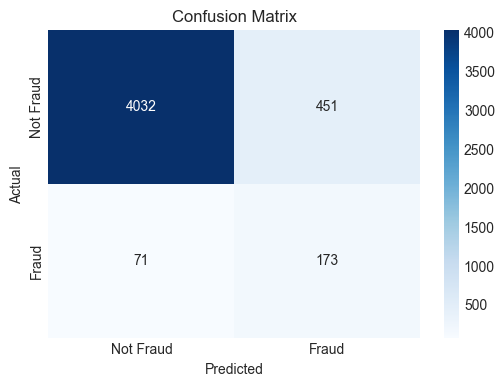

/var/folders/wp/6lr6qb7j2bv096grzncp2yyh0000gn/T/ipykernel_42132/730573742.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


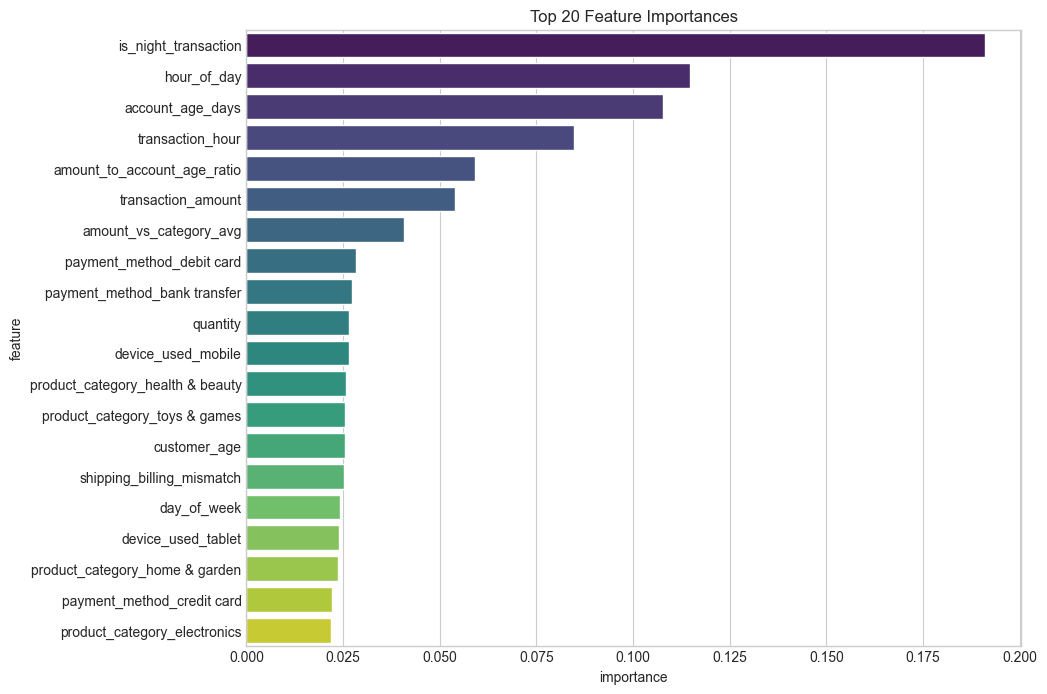

In [89]:
# --- EVALUATE THE MODEL ---
y_pred_xgb = best_model_xgb.predict(X_test)
y_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
top_features_xgb = evaluate_model(best_model_xgb, X_test, y_test, y_pred_xgb, y_proba_xgb)

# Simulating Advanced Scenarios 

## Intelligent Adversarial Attack Simulation: "The Chameleon"

In [90]:
fraud_indices = y_test[y_test == True].index
if not fraud_indices.empty:
    # Get original raw data for the entire test set
    X_test_raw_df = df.loc[X_test.index].copy()
    
    # Simulate the multi-pronged "Chameleon" attack on the raw data
    print("-> Attacker uses matching shipping/billing addresses.")
    X_test_raw_df.loc[fraud_indices, 'shipping_billing_mismatch'] = 0
    
    print("-> Attacker avoids suspicious night hours.")
    X_test_raw_df.loc[fraud_indices, 'is_night_transaction'] = 0
    X_test_raw_df.loc[fraud_indices, 'hour_of_day'] = 14 # A "safe" hour
    
    print("-> Attacker slows down to avoid velocity flags.")
    X_test_raw_df.loc[fraud_indices, 'time_since_last_transaction'] = 86400 # 1 day
    X_test_raw_df.loc[fraud_indices, 'trans_count_last_1h'] = 1
    
    print("-> Attacker normalizes transaction amount to category average.")
    # This is the most powerful attack: make the amount look normal for its category
    X_test_raw_df.loc[fraud_indices, 'transaction_amount'] = X_test_raw_df.loc[fraud_indices, 'category_avg_amount']
    # Recalculate features that depend on the modified transaction_amount
    X_test_raw_df['amount_vs_category_avg'] = X_test_raw_df['transaction_amount'] / (X_test_raw_df['category_avg_amount'] + 1e-6)
    X_test_raw_df['amount_to_account_age_ratio'] = X_test_raw_df['transaction_amount'] / (X_test_raw_df['account_age_days'] + 1)

    # Now, process this attacked raw data EXACTLY as we did the original data
    X_attacked_processed = X_test_raw_df.drop(columns=features_to_drop)
    X_attacked_processed = pd.get_dummies(X_attacked_processed, columns=categorical_features, drop_first=True)
    X_attacked_processed_aligned, _ = X_attacked_processed.align(X_train, axis=1, fill_value=0)
    X_attacked_processed_aligned[numerical_features] = scaler.transform(X_attacked_processed_aligned[numerical_features])

    # Predict using the final trained model
    y_prob_final_series = pd.Series(y_proba_xgb, index=y_test.index)
    prob_before_attack = y_prob_final_series[fraud_indices]
    
    prob_after_attack = best_model_xgb.predict_proba(X_attacked_processed_aligned)[:, 1]
    prob_after_attack_series = pd.Series(prob_after_attack, index=X_test.index)[fraud_indices]
    
    print("\nImpact of 'Chameleon' Adversarial Attack on Fraud Probability Predictions:")
    attack_summary = pd.DataFrame({'Prob_Before_Attack': prob_before_attack, 'Prob_After_Attack': prob_after_attack_series})
    attack_summary['Prob_Reduction'] = attack_summary['Prob_Before_Attack'] - attack_summary['Prob_After_Attack']

    print(attack_summary.sort_values('Prob_Reduction', ascending=False).head(10))
    
    avg_prob_before = prob_before_attack.mean()
    avg_prob_after = prob_after_attack_series.mean()
    print(f"\nAverage fraud probability dropped from {avg_prob_before:.2f} to {avg_prob_after:.2f} due to the intelligent attack.")
    
    threshold = 0.5
    evaded_count = ((prob_before_attack >= threshold) & (prob_after_attack_series < threshold)).sum()
    total_fraud = len(fraud_indices)
    print(f"Evasion Rate: {evaded_count}/{total_fraud} ({evaded_count/total_fraud:.1%}) of fraudulent transactions would now be misclassified as legitimate.")

else:
    print("No fraud cases in test set to simulate attack.")

-> Attacker uses matching shipping/billing addresses.
-> Attacker avoids suspicious night hours.
-> Attacker slows down to avoid velocity flags.
-> Attacker normalizes transaction amount to category average.

Impact of 'Chameleon' Adversarial Attack on Fraud Probability Predictions:
       Prob_Before_Attack  Prob_After_Attack  Prob_Reduction
17459            0.961881           0.125908        0.835972
19523            0.958091           0.160245        0.797846
15391            0.961886           0.166816        0.795070
18564            0.963850           0.247309        0.716542
5794             0.974469           0.258048        0.716421
21541            0.891955           0.194121        0.697833
6753             0.898997           0.211225        0.687772
2879             0.909853           0.233310        0.676544
10534            0.838305           0.256949        0.581356
14044            0.775262           0.200461        0.574801

Average fraud probability dropped from 0.69 

## Human-in-the-Loop & LLM Agent Simulation

In [91]:
def generate_case_summary(transaction_index, full_df, y_prob_series, top_features_list):
    trans_info = full_df.loc[transaction_index]
    fraud_prob = y_prob_series[transaction_index] * 100
    
    summary = f"""
    ===================================================
    LLM-Generated Case Summary for Fraud Analyst
    ===================================================
    Transaction ID: {trans_info['transaction_id']} | Customer ID: {trans_info['customer_id']}
    Fraud Probability: {fraud_prob:.1f}% -> Recommendation: {'High Priority Review' if fraud_prob > 60 else 'Low Priority'}

    Transaction Context:
    - Amount: ${trans_info['transaction_amount']:.2f} for '{trans_info['product_category']}'
    - Time: Hour {trans_info['hour_of_day']} ({'Night' if trans_info['is_night_transaction'] else 'Day'})
    - Customer Age: {trans_info['customer_age']} | Account Age: {trans_info['account_age_days']} days

    Key Risk Factors (Model Insights):
    -------------------------------------------
    """
    for feature in top_features_list:
        value = trans_info.get(feature) # Use the raw value for interpretability
        if value is not None and value != 0:
            if 'mismatch' in feature and value == 1:
                summary += f"- CRITICAL: Shipping and Billing Addresses DO NOT MATCH.\n"
            elif 'time_since' in feature and value < 3600: # Less than an hour
                 summary += f"- VELOCITY ALERT: Repeat transaction in {value/60:.1f} minutes.\n"
            elif 'amount_vs' in feature and value > 2.0:
                summary += f"- VALUE ANOMALY: Transaction amount is {value:.1f}x the typical average.\n"
            else:
                 summary += f"- {feature.replace('_', ' ').title()}: {value:.2f}\n"

    summary += "==================================================="
    return summary

if not fraud_indices.empty:
    # Find the transaction with the highest fraud probability in the test set
    high_risk_transaction_index_in_test = y_proba_xgb.argmax()
    high_risk_original_index = y_test.index[high_risk_transaction_index_in_test]
    
    y_prob_series = pd.Series(y_proba_xgb, index=y_test.index)
    
    case_report = generate_case_summary(high_risk_original_index, df, y_prob_series, top_features_xgb)
    print(case_report)
else:
    print("No fraud cases in test set to generate sample report.")


    LLM-Generated Case Summary for Fraud Analyst
    Transaction ID: 4115cd99-82f2-444a-b6c9-debe0c207d63 | Customer ID: 21abb0ba-82c8-436e-9476-173dd2b0dc5d
    Fraud Probability: 99.7% -> Recommendation: High Priority Review

    Transaction Context:
    - Amount: $2311.00 for 'health & beauty'
    - Time: Hour 22 (Day)
    - Customer Age: 29 | Account Age: 17 days

    Key Risk Factors (Model Insights):
    -------------------------------------------
    - Hour Of Day: 22.00
- Account Age Days: 17.00
- Transaction Hour: 3.00
- Amount To Account Age Ratio: 128.39
- Transaction Amount: 2311.00
- VALUE ANOMALY: Transaction amount is 10.2x the typical average.
- Quantity: 3.00
- Customer Age: 29.00
- Day Of Week: 1.00
